In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [5]:
## arrange data
# Load syllables to keep
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

# Process males data
df_male = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/long_v2_males_raw_usage_df_beh_age.parquet').astype(float)
df_male = df_male[keep_syllables].groupby(['age', 'uuid', 'mouse']).mean()

# Bin ages by week and handle first and last samples
ages = df_male.index.get_level_values('age')
weeks = (ages * 7) // 7
df_male['binned_age'] = weeks

sample_male_first = df_male.groupby(['mouse', 'binned_age']).first().reset_index()
sample_male_last = df_male.groupby(['mouse', 'binned_age']).last().reset_index()
sample_male_last['binned_age'] += 0.5

# Concatenate first and last samples
df_male_combined = pd.concat([sample_male_first, sample_male_last])
df_male_combined.rename(columns={'binned_age': 'age'}, inplace=True)

# Average per age or session
m_df = df_male_combined.groupby(['age', 'mouse']).mean()
m_df['sex'] = 'm'
m_df.set_index('sex', append=True, inplace=True)

# avarage per age or session
m_df = m_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## heatmaps

In [6]:
format_plots()

In [7]:
## male heatmap average

In [8]:
# get distance
data=avg_m_norm # un-normalized
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
vmax_value = np.percentile(dist_matrix, percentiles_up)
vmin_value = np.percentile(dist_matrix, percentiles_down)

In [9]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

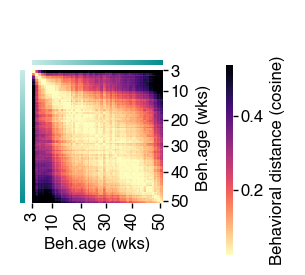

In [10]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value,
    vmax=vmax_value,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')

# Desired tick labels
desired_ages = [3, 10, 20, 30, 40, 50]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)
# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [11]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig3"/ '07_17_male_dist_matrix_minmax_cosine_beh_age.pdf')

In [12]:
## male heatmap indv

In [13]:
# get distance
data=m_norm # un-normalized
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
vmax_value_indv = np.percentile(dist_matrix, percentiles_up)
vmin_value_indv = np.percentile(dist_matrix, percentiles_down)

In [14]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

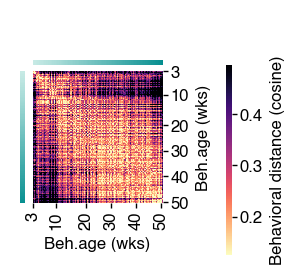

In [15]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value_indv,
    vmax=vmax_value_indv,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')

# Desired tick labels
desired_ages = [3, 10, 20, 30, 40, 50]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)
# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [16]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig3"/ '07_17_male_dist_matrix_minmax_cosine_all_sessions_beh_age.pdf')

In [17]:
## female

In [18]:
# Process females data
df_female = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/long_v2_females_raw_usage_df_beh_age.parquet').astype(float)
df_female = df_female[keep_syllables].groupby(['age', 'uuid', 'mouse']).mean()

# Bin ages by week and handle first and last samples
ages = df_female.index.get_level_values('age')
weeks = (ages * 7) // 7
df_female['binned_age'] = weeks

sample_female_first = df_female.groupby(['mouse', 'binned_age']).first().reset_index()
sample_female_last = df_female.groupby(['mouse', 'binned_age']).last().reset_index()
sample_female_last['binned_age'] += 0.5

# Concatenate first and last samples
df_female_combined = pd.concat([sample_female_first, sample_female_last])
df_female_combined.rename(columns={'binned_age': 'age'}, inplace=True)

# Average per age or session
f_df = df_female_combined.groupby(['age', 'mouse']).mean()
f_df['sex'] = 'f'
f_df.set_index('sex', append=True, inplace=True)

f_df = f_df.query('mouse!="F4_03"')

# avarage per age or session
f_df = f_df.sort_index(level='age')
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# zscore
z_f = f_df.apply(zscore, axis=0)
avg_z_f = avg_f_df.apply(zscore, axis=0)

# log
f_log = np.log(f_df+1e-3)
avg_f_log = np.log(avg_f_df+1e-3)

# log and z_score
z_log = f_log.apply(zscore, axis=0)
avg_z_log = avg_f_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_f = (
    avg_f_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])

In [19]:
# get distance
data=avg_f_norm # un-normalized
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
#vmax_value = np.percentile(dist_matrix, percentiles_up)
#vmin_value = np.percentile(dist_matrix, percentiles_down)

In [20]:
#colors for plotting
cmap2 = cmf
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

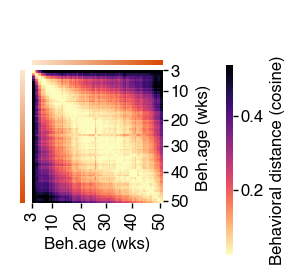

In [21]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    #data=squareform(pdist(data,metric='cosine')),
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value,
    vmax=vmax_value,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')

# Desired tick labels
desired_ages = [3, 10, 20, 30, 40, 50]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [22]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig3"/ '07_17_female_dist_matrix_minmax_cosine_beh_age.pdf')

In [23]:
## for femal all sessions

In [24]:
# get distance
data=f_norm # un-normalized
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
#vmax_value = np.percentile(dist_matrix, percentiles_up)
#vmin_value = np.percentile(dist_matrix, percentiles_down)

In [25]:
#colors for plotting
cmap2 = cmf
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

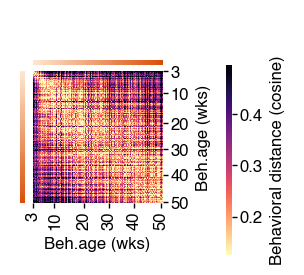

In [26]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    #data=squareform(pdist(data,metric='cosine')),
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value_indv,
    vmax=vmax_value_indv,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')

# Desired tick labels
desired_ages = [3, 10, 20, 30, 40, 50]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [27]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig3"/ '07_17_female_dist_matrix_minmax_cosine_all_sessions_beh_age.pdf')